# Incremental Stochastic Gradient Descent

## Setup

In [2]:
import numpy as np
import sys

import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

## Model

In [4]:
class ISGD:
    def __init__(self, n_user, n_item, k, l2_reg=0.01, learn_rate=0.05):
        self.k = k
        self.l2_reg = l2_reg
        self.learn_rate = learn_rate
        self.known_users = np.array([])
        self.known_items = np.array([])
        self.n_user = n_user
        self.n_item = n_item
        self.A = np.random.normal(0., 0.1, (n_user, self.k))
        self.B = np.random.normal(0., 0.1, (n_item, self.k))

    def update(self, u_index, i_index):
        if u_index not in self.known_users: self.known_users = np.append(self.known_users, u_index)
        u_vec = self.A[u_index]

        if i_index not in self.known_items: self.known_items = np.append(self.known_items, i_index)
        i_vec = self.B[i_index]

        err = 1. - np.inner(u_vec, i_vec)
        self.A[u_index] = u_vec + self.learn_rate * (err * i_vec - self.l2_reg * u_vec)
        self.B[i_index] = i_vec + self.learn_rate * (err * u_vec - self.l2_reg * i_vec)

    def recommend(self, u_index, N, history_vec):
        """
        Recommend Top-N items for the user u
        """

        if u_index not in self.known_users: raise ValueError('Error: the user is not known.')

        recos = []
        scores = np.abs(1. - np.dot(np.array([self.A[u_index]]), self.B.T)).reshape(self.B.shape[0])

        cnt = 0
        for i_index in np.argsort(scores):
            if history_vec[i_index] == 1: continue
            recos.append(i_index)
            cnt += 1
            if cnt == N: break

        return recos

## Dataset

In [1]:
!wget -q --show-progress http://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip

ml-1m.zip           100%[===================>]   5.64M  4.15MB/s    in 1.4s    
Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


In [9]:
ratings = []

with open('ml-1m/ratings.dat') as f:
    lines = list(map(lambda l: list(map(int, l.rstrip().split('::'))), f.readlines()))
    for l in lines:
        # Since we consider positive-only feedback setting, ratings < 5 will be excluded.
        if l[2] == 5: ratings.append(l)

ratings = np.asarray(ratings)
ratings.shape

(226310, 4)

sorted by timestamp

In [10]:
ratings = ratings[np.argsort(ratings[:, 3])]
ratings[:10]

array([[     6040,       593,         5, 956703954],
       [     6040,      2019,         5, 956703977],
       [     6040,      3111,         5, 956704056],
       [     6040,       213,         5, 956704056],
       [     6040,       912,         5, 956704191],
       [     6040,       919,         5, 956704191],
       [     6040,      2503,         5, 956704191],
       [     6040,       527,         5, 956704219],
       [     6040,      1252,         5, 956704257],
       [     6040,       649,         5, 956704257]])

In [11]:
users = set([])
items = set([])

for u, i, r, t in ratings:
    users.add(u)
    items.add(i)

users = list(users)
items = list(items)

n_user = len(users)
n_item = len(items)

n_user, n_item

(6014, 3232)

## Training

Simple Moving Average (SMA) with window size n=5000

In [13]:
window_size = 5000 # for SMA
N = 10 # recall@10

history_mat = np.zeros((n_user, n_item))

# initialize
isgd = ISGD(n_user, n_item, k=100)

# to avoid cold-start, train initial 20% samples
n_ratings = ratings.shape[0]
n_train = int(n_ratings * 0.2)

for ri in range(n_train):
    u, i, rating, timestamp = ratings[ri]
    u_index = users.index(u)
    i_index = items.index(i)
    isgd.update(u_index, i_index)
    history_mat[u_index, i_index] = 1

avgs = []
sma = []

for ri in range(n_train, n_ratings):
    u, i, rating, timestamp = ratings[ri]
    u_index = users.index(u)
    i_index = items.index(i)
    
    # 1.
    if u_index in isgd.known_users:
        # If u is a known user, use the current model to recommend N items,
        recos = isgd.recommend(u_index, N, history_mat[u_index])
        
        # 2. Score the recommendation list given the true observed item i
        recall = 1 if (i_index in recos) else 0
        
        sma.append(recall)
        n = len(sma)
        if n > window_size: 
            del sma[0]
            n -= 1
        avgs.append(sum(sma) / float(n))
    
    # 3. update the model with the observed event
    isgd.update(u_index, i_index)
    history_mat[u_index, i_index] = 1

## Evaluation

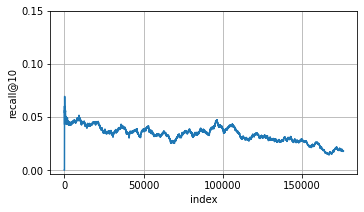

In [14]:
fig, ax = plt.subplots()
ax.plot(range(len(avgs)), avgs)
ax.set_xlabel('index')
ax.set_ylabel('recall@10')
ax.grid(True)
ax.set_xticks([0, 50000, 100000, 150000])
ax.set_yticks([0.00, 0.05, 0.10, 0.15])
fig.set_size_inches((5.5,3))
fig.patch.set_alpha(0.0)
plt.show()